In [ ]:
# This notebook reads in .csvs containing PSF data and makes
# nice plots

# created 2018 Oct 25 by E.S.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.ma as ma
import os.path
from scipy import misc, signal, ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata.utils import extract_array
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion
from pyregion import read_region_as_imagecoord, get_mask
import csv
import time
import pickle 
% matplotlib inline

In [4]:
stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/'+
        '180507_fizeau_altair/03_ramp_removed_pca_background_subted/')

In [ ]:
###################################

In [2]:
import pandas as pd
df = pd.read_csv("altair_psf_data_run20181025.csv")

In [3]:
df.keys()

Index([u'framenum', u'ampl_med_highFreqPerfect_L',
       u'ampl_med_highFreqPerfect_R', u'ampl_med_lowFreqPerfect',
       u'ampl_med_rect', u'ampl_normVec_highFreqPerfect_L_x',
       u'ampl_normVec_highFreqPerfect_L_y',
       u'ampl_normVec_highFreqPerfect_R_x',
       u'ampl_normVec_highFreqPerfect_R_y', u'ampl_normVec_lowFreqPerfect_x',
       u'ampl_normVec_lowFreqPerfect_y', u'ampl_normVec_rect_x',
       u'ampl_normVec_rect_y', u'phase_med_highFreqPerfect_L',
       u'phase_med_highFreqPerfect_R', u'phase_med_lowFreqPerfect',
       u'phase_med_rect', u'phase_normVec_highFreqPerfect_L_x',
       u'phase_normVec_highFreqPerfect_L_y',
       u'phase_normVec_highFreqPerfect_R_x',
       u'phase_normVec_highFreqPerfect_R_y', u'phase_normVec_lowFreqPerfect_x',
       u'phase_normVec_lowFreqPerfect_y', u'phase_normVec_rect_x',
       u'phase_normVec_rect_y'],
      dtype='object')

In [5]:
len(df["ampl_med_highFreqPerfect_L"])

6981

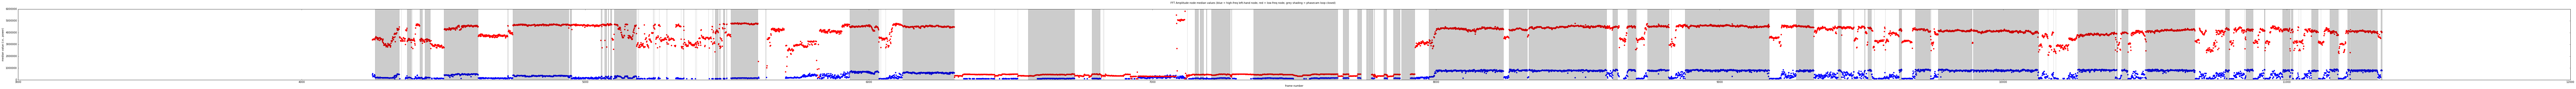

In [53]:
# some FFT amplitude plots

plt.figure(figsize=(180,5))
plt.scatter(df["framenum"],df["ampl_med_highFreqPerfect_L"], color='b')
plt.scatter(df["framenum"],df["ampl_med_lowFreqPerfect"], color='r')
#plt.scatter(df["framenum"],df["ampl_med_rect"], color='k')

# Phase controlled
plt.fill_between(full_table["FRAMENUM"], 0, 6000000, where=full_table["PCCLOSED"]==1, \
                facecolor='black', label='PCCLOSED = True', alpha=0.2)

plt.ylim([0,6000000])

plt.suptitle('FFT Amplitude node median values (blue = high-freq left-hand node; red = low-freq node; grey shading = phasecam loop closed)')
plt.xlabel('frame number')
plt.ylabel('median value (i.e., power)')

#plt.savefig('junk2.png')

#plt.show()

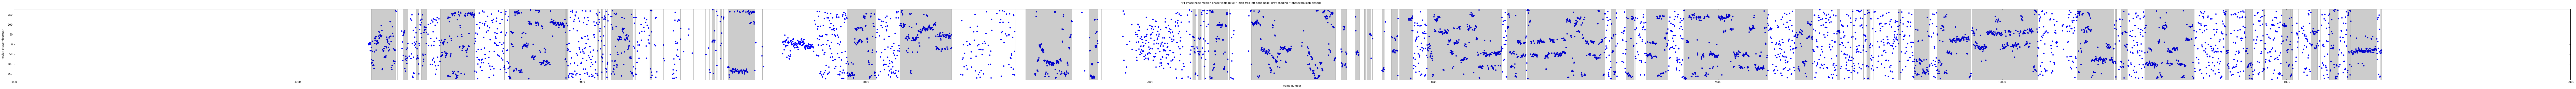

In [55]:
# some FFT phase plots

plt.figure(figsize=(180,5))
plt.scatter(df["framenum"],df["phase_med_highFreqPerfect_L"], color='b')
#plt.scatter(df["framenum"],df["phase_med_lowFreqPerfect"], color='r')
#plt.scatter(df["framenum"],df["phase_med_rect"], color='k')

plt.fill_between(full_table["FRAMENUM"], -180, 180, where=full_table["PCCLOSED"]==1, \
                facecolor='black', label='PCCLOSED = True', alpha=0.2)

plt.ylim([-180,180])

plt.suptitle('FFT Phase node median phase value (blue = high-freq left-hand node; grey shading = phasecam loop closed)')
plt.xlabel('frame number')
plt.ylabel('median phase (degrees)')

#plt.savefig('junk.png')

#plt.show()

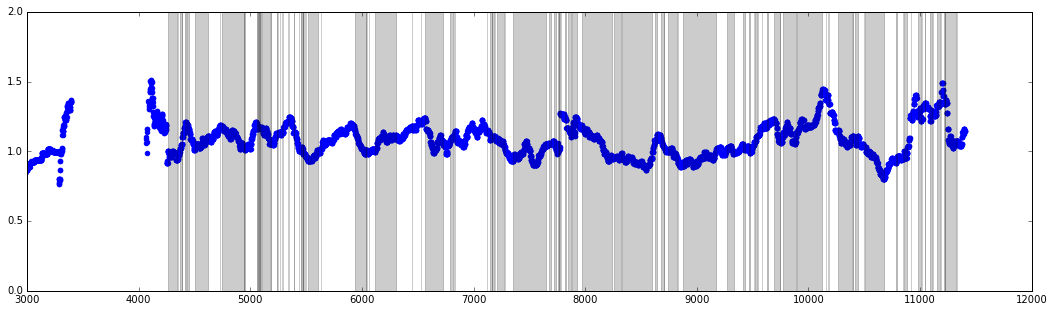

In [34]:
plt.figure(figsize=(18,5))
plt.scatter(full_table["FRAMENUM"],full_table["SEEING"], color='b')

#plt.scatter(full_table["FRAMENUM"],full_table["WINDSPD"], color='b')

#plt.scatter(df["framenum"],df["ampl_med_lowFreqPerfect"], color='r')
#plt.scatter(df["framenum"],df["ampl_med_rect"], color='k')

# Phase controlled
plt.fill_between(full_table["FRAMENUM"], 0, 2, where=full_table["PCCLOSED"]==1, \
                facecolor='black', label='PCCLOSED = True', alpha=0.2)

plt.ylim([0,2])
plt.xlim([3000,12000])
plt.show()

In [18]:
# plot other meta-data as a function of 
# frame number to compare

# read in FITS header data to get filter info
full_table = pd.read_csv("../lbti_altair_fizeau/fizeau_altair_180507_metadata.csv")

# sort table by frame number (a few are out of order)
full_table.sort_values(["FRAMENUM"], inplace=True)
full_table = full_table.reset_index(drop=True) # reset indices and don't keep the old ones

/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (13,80,81,84,88,92,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
print(list(full_table.keys()))

['Unnamed: 0', 'ACTEXP', 'AGE_STOP', 'BADROWS', 'BAYXCUR', 'BAYXREQ', 'BAYYCUR', 'BAYYREQ', 'BITPIX', 'BSCALE', 'BZERO', 'COMMENT', 'CTLRTEMP', 'DATAFLAG', 'DATE-OBS', 'DETECTOR', 'DETTEMP', 'DET_OP', 'DIMMFLUX', 'EXPMODE', 'EXPTIME', 'EXTEND', 'FILENAME', 'FLAG', 'FPCAZM', 'FPCAZS', 'FPCELM', 'FPCELS', 'FPCPISTM', 'FPCPISTS', 'FRAME', 'FRAMENUM', 'GAIN', 'GROUP', 'IL_HORIZ', 'INSTRUME', 'ITIME', 'KTCREMOV', 'LBTTEMP', 'LBT_AIRM', 'LBT_ALT', 'LBT_AZ', 'LBT_DEC', 'LBT_LST', 'LBT_LXOS', 'LBT_LYOS', 'LBT_PARA', 'LBT_RA', 'LBT_RXOS', 'LBT_RYOS', 'LBT_UTC', 'LCMODES', 'LGAIN', 'LLOOPON', 'LMIRFW25', 'LMIR_FW1', 'LMIR_FW2', 'LMIR_FW3', 'LMIR_FW4', 'LOFFSETX', 'LOFFSETY', 'LOFFSETZ', 'LSLNULL', 'LSTATUS', 'LTTMODUL', 'LWCCDBIN', 'LWCCDFRQ', 'LWIND1S', 'MAGWHEEL', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NCBMDVT', 'NCOADDS', 'NDROPS', 'NGROUPS', 'NIC_NAC', 'NIL_NDFW', 'NIL_OPW', 'NIL_PRW', 'NLDCRC', 'NLMGTLT', 'NLNCNC', 'NLPPLTLT', 'NLWNTRNS', 'NMCLFSS', 'NMCMSLD', 'NOCHAVG', 'NODPOS', 'NOMICFW1', 'NOMIC

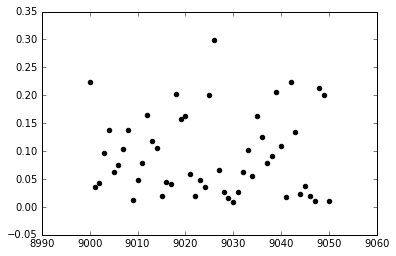

In [32]:
#plt.scatter(df["framenum"],df["phase_normVec_highFreqPerfect_L_x"], color='b')
#plt.scatter(df["framenum"],df["phase_normVec_highFreqPerfect_L_y"], color='r')
plt.scatter(df["framenum"],np.sqrt(np.power(df["phase_normVec_highFreqPerfect_L_x"].values,2.),
                                   np.power(df["phase_normVec_highFreqPerfect_L_y"].values,2.)), color='k')
plt.show()

In [31]:
df["phase_normVec_highFreqPerfect_L_x"].values

array([-0.22388664,  0.03532201,  0.04263646,  0.09670333,  0.13806682,
        0.06264305,  0.07437832,  0.10406917,  0.13770817,  0.0130518 ,
        0.04849938,  0.07805505,  0.16507925, -0.11828314,  0.10587168,
        0.01997622,  0.04414176,  0.04174093,  0.20225613,  0.1573356 ,
        0.16340876, -0.05937441,  0.01921177,  0.04834072,  0.03569861,
        0.20098138,  0.29882959, -0.06531678,  0.02702249, -0.01544348,
       -0.00905657, -0.02664275,  0.06245704,  0.10148444,  0.05575474,
        0.16293086,  0.1253292 ,  0.07855067,  0.09040437,  0.20554595,
        0.10896996,  0.01830214,  0.22330628,  0.13376922, -0.02249788,
        0.03710376,  0.01961676,  0.01056479,  0.21352153,  0.20020515,
       -0.01058913])

In [ ]:
# read in PSF analysis file and make plots

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
psf_analysis = pd.read_csv("psf_analysis_altair_data.csv", na_values="--")

In [36]:
[print(i) for i in psf_analysis.keys()]

framenum
amp_med_highFreqPerfect_L
amp_med_highFreqPerfect_R
amp_med_lowFreqPerfect
amp_med_rect
amp_normVec_highFreqPerfect_L_x
amp_normVec_highFreqPerfect_L_y
amp_normVec_highFreqPerfect_R_x
amp_normVec_highFreqPerfect_R_y
amp_normVec_lowFreqPerfect_x
amp_normVec_lowFreqPerfect_y
amp_normVec_rect_x
amp_normVec_rect_y
arg_med_highFreqPerfect_L
arg_med_highFreqPerfect_R
arg_med_lowFreqPerfect
arg_med_rect
arg_normVec_highFreqPerfect_L_x
arg_normVec_highFreqPerfect_L_y
arg_normVec_highFreqPerfect_R_x
arg_normVec_highFreqPerfect_R_y
arg_normVec_lowFreqPerfect_x
arg_normVec_lowFreqPerfect_y
arg_normVec_rect_x
arg_normVec_rect_y


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

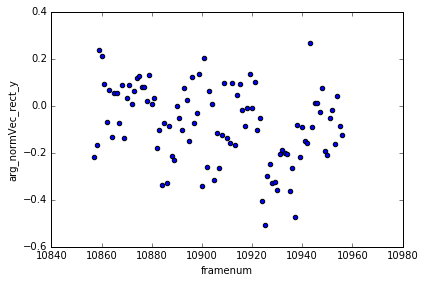

In [46]:
x_axis = "framenum"
y_axis = "arg_normVec_rect_y"
plt.scatter(psf_analysis[x_axis][6500:6600],psf_analysis[y_axis][6500:6600])
plt.xlabel(x_axis)
plt.ylabel(y_axis)
#plt.ylim([-0.00005,0.00005])
plt.tight_layout()
plt.savefig(y_axis+"_vs_"+x_axis+"_testDetail.pdf")
#plt.show()

In [ ]:
# how are FFTs affected by
# 1. fringe movement
# 2. changing visibility
# 3. stuff listed in my table

# ... and how good am I at finding the center of the PSF?

In [ ]:
# based on the images, decide whether to move HPC in piston, tip, tilt
# iterate?
# maybe I don't want to move HPC in piston, because I found the center of the envelope with the grism,
# and Phasecam isn't closed yet